In [228]:
import pandas as pd
import numpy as np
from lib import raw_ds_columns, calc_ts_diff
from visualization import display_point_process_events
from scipy.optimize import minimize
from tick.hawkes import HawkesSumExpKern
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
%matplotlib inline

In [229]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot, row, column, grid
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [336]:
# session = "AM"
# session = "MID"
session = "PM"

raw_dataset_name = "ticks_50dc"
# raw_dataset_name = "ticks_60dc"
# raw_dataset_name = "ticks_60dp"


In [337]:
raw_ticks = pd.read_csv("final_dataset/{}/{}_{}_AAPL.csv".format(session, session, raw_dataset_name), header=None)
raw_ticks.columns = raw_ticks.iloc[0]
raw_ticks = raw_ticks.iloc[1:]
raw_ticks = raw_ticks.iloc[:, 1:]



raw_ticks["Bid_time"] = raw_ticks["Bid_time"].astype(int)
raw_ticks["Mid_IV"] = raw_ticks["Mid_IV"].astype(float)
raw_ticks["Mid_price"] = raw_ticks["Mid_price"].astype(float)

# convert in micro
raw_ticks = raw_ticks.sort_values("Bid_time")
raw_ticks["Bid_time"] = raw_ticks["Bid_time"] / 1000000

# ticks are throttled to 1ms sometimes - redistribute
def distribute_ticks(df):
    results = []
    for name, group in df.groupby('Bid_time'):
        len_ = len(group)
        start_time, end_time = int(name) - len_, int(name)
        times = sorted(np.random.choice(range(start_time, end_time), len_, replace=False))
        group["Bid_time"] = times
        results.append(group)
    return pd.concat(results)

# raw_ticks = distribute_ticks(raw_ticks)
# raw_ticks = raw_ticks.groupby(['Bid_time']).mean().reset_index()
raw_ticks = raw_ticks.sort_values("Bid_time")
# time_start = min(raw_ticks["Bid_time"])
# raw_ticks["Bid_time"] = raw_ticks["Bid_time"] - time_start


# raw_ticks = raw_ticks.loc[(raw_ticks["Bid_time"] > 9.42e7) & (raw_ticks["Bid_time"] < 9.426e7)]

In [338]:
# raw_ticks = raw_ticks.sort_values("Bid_time")
raw_ticks["Bid_time"].is_monotonic_increasing

True

In [339]:
raw_ticks

,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta
1,52500258.0,310.0,12.587500,317.36,0.232566,0.6491677467987955
2,52500259.0,309.64285714285717,12.653571,317.36000000000007,0.227878,0.658037001176659
3,52500260.0,310.35714285714283,12.178571,317.36000000000007,0.227081,0.6454854912350427
4,52500261.0,310.5,12.127500,317.35999999999996,0.228176,0.6423319274217576
5,52500269.0,310.0,12.437500,317.36,0.228144,0.6514396795795463
...,...,...,...,...,...,...
17930,53699754.0,310.0,12.575000,317.68,0.226011,0.658257368623083
17931,53699775.0,307.5,14.200000,317.68,0.225463,0.7029669119910764
17932,53699787.0,312.5,10.925000,317.68,0.222488,0.6133585340952763
17933,53699788.0,307.5,13.275000,317.68,0.195767,0.727269120524987


In [340]:
test_ = calc_ts_diff(raw_ticks, keys=['Mid_price', 'Bid_time', 'Mid_IV'])["Bid_time_diff"]

In [341]:
print(max(test_))
print(min(test_))

2643.0
1.0


In [342]:
raw_ticks_diff = calc_ts_diff(raw_ticks, keys=['Mid_price', 'Bid_time', 'Mid_IV'])
raw_ticks_diff["Mid_price_ret"] = np.log1p(raw_ticks["Mid_price"].pct_change())
raw_ticks_diff["Mid_IV_diff_sign"] = np.sign(raw_ticks_diff["Mid_IV_diff"])


duration_threshold = 5e6 #\mus

diff_arr = np.array(raw_ticks_diff["Bid_time_diff"])
ts_arr = np.array(raw_ticks_diff["Bid_time"])
diff_ind = list(np.where(diff_arr > duration_threshold)[0])
ts_ind = [diff_ind[k] - diff_ind[k-1] if k != 0 else diff_ind[k] for k in range(0, len(diff_ind))]
def recursive_shift(ts_series, diff_series, ts_ind, diff_ind):
    if ts_ind:
        ts_idx_ = ts_ind.pop(0)
        diff_idx_ = diff_ind.pop(0)
        shift_val = diff_series[diff_idx_]
        lhs = ts_series[:ts_idx_]
        rhs = ts_series[ts_idx_:]
        return np.concatenate([lhs, recursive_shift(rhs - shift_val, diff_series, ts_ind, diff_ind)])
    return np.array(ts_series)

raw_ticks_diff["Bid_time"] = recursive_shift(ts_arr, diff_arr, ts_ind, diff_ind).tolist()
diffs = np.diff(raw_ticks_diff["Bid_time"])
raw_ticks_diff["Bid_time_diff"] = np.insert(diffs, 0, list(raw_ticks_diff["Bid_time_diff"])[0], axis=0).tolist()


raw_ticks_diff.head(1)

/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a c

,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
2,52500259.0,309.64285714285717,12.653571,317.36000000000007,0.227878,0.658037001176659,0.066071,1.0,-0.004688,0.005235,-1.0


In [343]:
raw_ticks_diff

,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
2,52500259.0,309.64285714285717,12.653571,317.36000000000007,0.227878,0.658037001176659,0.066071,1.0,-0.004688,0.005235,-1.0
3,52500260.0,310.35714285714283,12.178571,317.36000000000007,0.227081,0.6454854912350427,-0.475000,1.0,-0.000797,-0.038262,-1.0
4,52500261.0,310.5,12.127500,317.35999999999996,0.228176,0.6423319274217576,-0.051071,1.0,0.001095,-0.004202,1.0
5,52500269.0,310.0,12.437500,317.36,0.228144,0.6514396795795463,0.310000,8.0,-0.000031,0.025241,-1.0
6,52500461.0,310.0,12.506250,317.36000000000007,0.230172,0.6503864139947524,0.068750,192.0,0.002028,0.005512,1.0
...,...,...,...,...,...,...,...,...,...,...,...
17930,53699754.0,310.0,12.575000,317.68,0.226011,0.658257368623083,-1.625000,38.0,0.000548,-0.121531,1.0
17931,53699775.0,307.5,14.200000,317.68,0.225463,0.7029669119910764,1.625000,21.0,-0.000548,0.121531,-1.0
17932,53699787.0,312.5,10.925000,317.68,0.222488,0.6133585340952763,-3.275000,12.0,-0.002975,-0.262188,-1.0
17933,53699788.0,307.5,13.275000,317.68,0.195767,0.727269120524987,2.350000,1.0,-0.026721,0.194829,-1.0


In [344]:
raw_ticks_diff["Bid_time"].is_monotonic_increasing

True

In [345]:

def distr_hist(data, bins=200):
    hist, edges = np.histogram(data, density=True, bins=bins)
    p = figure(title=data.name)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")
    return p

def count_hist(data, bins):
    p = figure(title="Bid_time", x_axis_label='Bid Time')
    edges = np.linspace(min(data["Bid_time"]), max(data["Bid_time"]), bins)
    hist_plus, hist_minus = [], []
    for i in range(1, len(edges)):
        l, r = edges[i - 1], edges[i]
        bucket_ = data[(data["Bid_time"] >= l) & (data["Bid_time"] <= r)]
        hist_plus.append(len(bucket_[bucket_["Mid_IV_diff_sign"] > 0]))
        hist_minus.append(len(bucket_[bucket_["Mid_IV_diff_sign"] < 0]))
    p.quad(top=hist_plus, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", fill_color="green", fill_alpha=0.6, legend_label="Up tick")
    p.quad(top=hist_minus, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", fill_color="red", fill_alpha=0.6, legend_label="Down tick")
    return p

def mean_hist(data, mean_col, bins):
    p = figure(title=mean_col, x_axis_label='Bid Time')
    edges = np.linspace(min(data["Bid_time"]), max(data["Bid_time"]), bins)
    hist = []
    for i in range(1, len(edges)):
        l, r = edges[i - 1], edges[i]
        hist.append(np.mean(data[(data["Bid_time"] >= l) & (data["Bid_time"] <= r)][mean_col]))
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", legend_label="{} mean value".format(mean_col))
    return p

def show_ts_df(ts_df):
    p2 = count_hist(ts_df, bins=100)

    p3_a = mean_hist(ts_df, "Mid_price", bins=300)
    p3_b = distr_hist(ts_df["Mid_price_ret"], bins=300)
    
    p4_a = mean_hist(ts_df, "Mid_IV", bins=300)
    p4_b = distr_hist(ts_df["Mid_IV_diff"])
    grid_ = grid(column(row(p2, sizing_mode='stretch_width'), row(p3_a, p3_b, sizing_mode='stretch_width'), row(p4_a, p4_b, sizing_mode='stretch_width')))

    show(grid_)


In [346]:

show_ts_df(raw_ticks_diff)

In [347]:
def quantile_analysis(data, columns):
    rows = []
    for col in columns:
        data_ = abs(data[col])
        duration_Q99 = np.quantile(data_, 0.99)
        duration_Q95 = np.quantile(data_, 0.95)
        duration_Q90 = np.quantile(data_, 0.90)
        duration_MAX = max(data_)
        duration_N = len(data_)
        duration_N_gt_2_Q99 = len(data_[data_ > 2*duration_Q99])
        duration_N_gt_Q99 = len(data_[data_ > duration_Q99])
        duration_frac_N_gt_2_Q99 = "{:.2f}%".format((duration_N_gt_2_Q99 / duration_N) * 100)
        duration_frac_N_gt_Q99 = "{:.2f}%".format((duration_N_gt_Q99 / duration_N) * 100)
        rows.append([col, duration_Q90, duration_Q95, duration_Q99, duration_MAX, duration_N, duration_N_gt_Q99, duration_frac_N_gt_Q99, 
                                                                                              duration_N_gt_2_Q99, duration_frac_N_gt_2_Q99])
    return pd.DataFrame(
        rows, 
        columns=["Name", "Q90", "Q95", "Q99", "Max", "N", "N>Q99", "Fraction N>Q99", "N>2*Q99", "Fraction N>2*Q99"]
    )


In [348]:
quantile_analysis(raw_ticks_diff, ["Bid_time_diff", "Mid_price_ret", "Mid_IV_diff"])

,Name,Q90,Q95,Q99,Max,N,N>Q99,Fraction N>Q99,N>2*Q99,Fraction N>2*Q99
0,Bid_time_diff,172.000000,302.000000,740.000000,2643.000000,17933,179,1.00%,21,0.12%
1,Mid_price_ret,0.265236,0.266629,0.283079,0.443301,17933,180,1.00%,0,0.00%
2,Mid_IV_diff,0.006653,0.018021,0.032837,0.067399,17933,179,1.00%,1,0.01%


## Outliers removal

In [349]:
def filter_gt_Q99(df, columns):
    for col in columns:
        df = df.loc[~(df[col] > 2*np.quantile(df[col], 0.99))]
    return df

def filter_zeros(df, columns):
    for col in columns:
        df = df[df[col] != 0.0]
    return df

def remove_n_first(df, n):
    return df.iloc[n:]


In [350]:
def delta_trimmed_sample_stats(data, delta):
    sample_mean = np.mean(data[data<np.quantile(data,1-delta)])
    sample_std = np.std(data[data<np.quantile(data,1-delta)])
    return sample_mean, sample_std

def is_outlier(value, mean, std, gamma):
    if abs(value-mean)<3*std+gamma:
        return True
    return False

def assign(data_slice, value, delta, gamma):
        mean, std = delta_trimmed_sample_stats(data_slice, delta)
        return is_outlier(value, mean,std, gamma)


def k_neigh_remove(data, delta, k, gamma):
    """
    Delta is the percantage of trimming to calculate adjusted sample statistics.
    Delta should be determined  on the basis of frequesncy of outliers,
    the higher the frequency the larger is delta. Delta should be between 0 and 1.
    
    k gives a radius of neighbourhood obervations.
    Should be chosen on the basis of trading intensity. Less trading activity corresponds to smaller k.
    
    Gamma is a granularity parameter. It's role is to avoid zero std produced by a sequence of k equal prices.
    Gamma should be a multiple of the minimum price variation allowed.
    """
    n=len(data)
    non_outliers_series=pd.Series([0]*n)
    
    for i in range(n):
        if i<k//2:
            non_outliers_series[i] = assign(data.iloc[:k], data.iloc[i], delta, gamma)
        elif n-i<k//2:
            non_outliers_series[i] = assign(data.iloc[n-k:], data.iloc[i], delta, gamma)
        else:
            non_outliers_series[i] = assign(data.iloc[k//2:k+k//2], data.iloc[i], delta, gamma)
    return non_outliers_series

In [351]:
def remove_outliers(data):
    df = data.copy()
    print("Starting dataset size: {}".format(len(df)))
    df = filter_gt_Q99(df, ["Bid_time_diff"])
    print("Dataset after Q99 bid time cleaning size: {}".format(len(df)))
    df = filter_zeros(df, ["Mid_price_ret"])
    print("Dataset after 0 return cleaning size: {}".format(len(df)))
    df = filter_zeros(df, ["Bid_time_diff"])
    print("Dataset after 0 bid time diff cleaning size: {}".format(len(df)))
    keep_mid_price = k_neigh_remove(df['Mid_price_ret'], delta=0.05, k=20, gamma=0.002)
    keep_iv_diff = k_neigh_remove(df['Mid_IV_diff'], delta=0.05, k=20, gamma=0.002)    
    keep_df = np.logical_and(keep_mid_price, keep_iv_diff)
#     df = filter_zeros(df, columns)
#     one of the datasets has a supermassive black hole between the ticks
#     df = remove_n_first(df, 5)
    df.reset_index(drop=True, inplace=True)
    df = df[keep_df]
    print("Dataset after knn mid price/IV cleaning size: {}".format(len(df)))
    return df
        

In [352]:
filtered_df = remove_outliers(raw_ticks_diff)
filtered_df.head()

Starting dataset size: 17933
Dataset after Q99 bid time cleaning size: 17912
Dataset after 0 return cleaning size: 15053
Dataset after 0 bid time diff cleaning size: 15053
Dataset after knn mid price/IV cleaning size: 14863


,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
0,52500259.0,309.64285714285717,12.653571,317.36000000000007,0.227878,0.658037001176659,0.066071,1.0,-0.004688,0.005235,-1.0
1,52500260.0,310.35714285714283,12.178571,317.36000000000007,0.227081,0.6454854912350427,-0.475000,1.0,-0.000797,-0.038262,-1.0
2,52500261.0,310.5,12.127500,317.35999999999996,0.228176,0.6423319274217576,-0.051071,1.0,0.001095,-0.004202,1.0
3,52500269.0,310.0,12.437500,317.36,0.228144,0.6514396795795463,0.310000,8.0,-0.000031,0.025241,-1.0
4,52500461.0,310.0,12.506250,317.36000000000007,0.230172,0.6503864139947524,0.068750,192.0,0.002028,0.005512,1.0


In [353]:
filtered_df = calc_ts_diff(filtered_df, keys=['Mid_price', 'Bid_time', 'Mid_IV'])
filtered_df["Mid_price_ret"] = np.log1p(filtered_df["Mid_price"].pct_change())
filtered_df["Mid_IV_diff_sign"] = np.sign(filtered_df["Mid_IV_diff"])
filtered_df = filtered_df.iloc[1:]
filtered_df.head()

,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
2,52500261.0,310.5,12.12750,317.35999999999996,0.228176,0.6423319274217576,-0.051071,1.0,0.001095,-0.004202,1.0
3,52500269.0,310.0,12.43750,317.36,0.228144,0.6514396795795463,0.310000,8.0,-0.000031,0.025241,-1.0
4,52500461.0,310.0,12.50625,317.36000000000007,0.230172,0.6503864139947524,0.068750,192.0,0.002028,0.005512,1.0
5,52500463.0,310.0,12.42500,317.36000000000007,0.227775,0.6516334051857697,-0.081250,2.0,-0.002397,-0.006518,-1.0
6,52501101.0,310.8333333333333,11.87500,317.335,0.227251,0.6362147325923218,-0.550000,638.0,-0.000525,-0.045275,-1.0


In [354]:
filtered_df["Bid_time"].is_monotonic_increasing

True

In [355]:
quantile_analysis(filtered_df, ["Bid_time_diff", "Mid_price_ret", "Mid_IV_diff"])

,Name,Q90,Q95,Q99,Max,N,N>Q99,Fraction N>Q99,N>2*Q99,Fraction N>2*Q99
0,Bid_time_diff,214.000000,368.000000,893.800000,2674.000000,14861,149,1.00%,22,0.15%
1,Mid_price_ret,0.265550,0.266629,0.274839,0.374855,14861,149,1.00%,0,0.00%
2,Mid_IV_diff,0.007278,0.017208,0.029746,0.056999,14861,149,1.00%,0,0.00%


## Post-filtering analysis

1) Plot of mid-price changes
2) Plot intra-day seasonality - autoregressive conditional durations (can look up if necessary)
3) ACFfiltered_df['Mid_price_ret']

In [356]:
def autocorrelation(series, lag_list):
    autocorr_list=[]
    for lag in lag_list:
        autocorr_list.append(series.autocorr(lag=lag))
    result=pd.DataFrame(data=autocorr_list, index=lag_list)
    return result.T

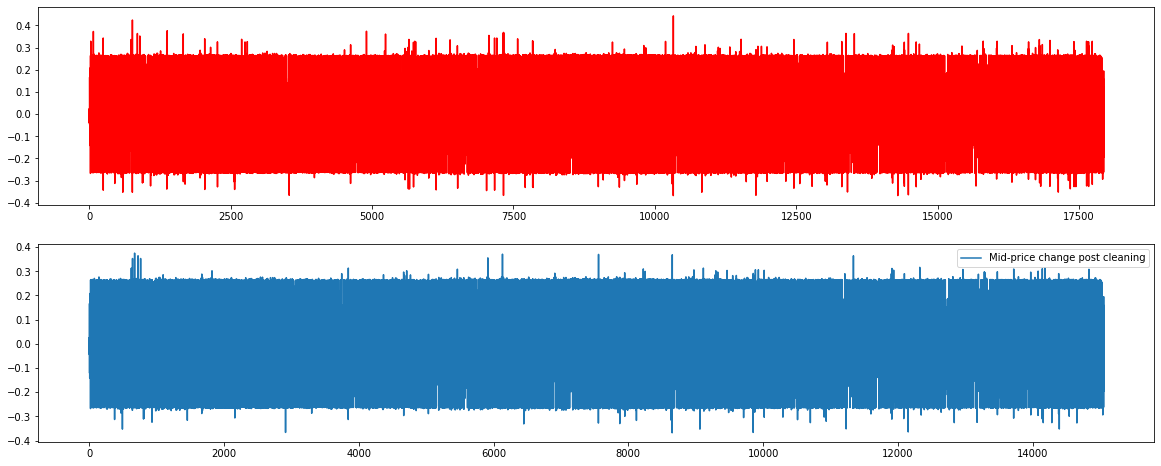

In [357]:
# mid-price changes
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(raw_ticks_diff['Mid_price_ret'],label='Mid-price change prior to cleaning', color ='r')
ax[1].plot(filtered_df['Mid_price_ret'], label='Mid-price change post cleaning')
# ax[0].set_ylim((-80,80))
plt.legend()

In [358]:
autocorrelation(raw_ticks_diff['Bid_time_diff'], [1,2,3,4,5])

,1,2,3,4,5
0,0.191457,0.151186,0.145131,0.096453,0.094161


In [359]:
autocorrelation(filtered_df['Bid_time_diff'], [1,2,3,4,5])


,1,2,3,4,5
0,0.183761,0.165713,0.124586,0.101329,0.091542


In [360]:
show_ts_df(filtered_df)

## Split Into N+ and N-

In [361]:
n_plus_ts, n_minus_ts = filtered_df.loc[filtered_df["Mid_IV_diff_sign"] > 0], \
                        filtered_df.loc[filtered_df["Mid_IV_diff_sign"] < 0]

In [362]:

n_minus_ts.to_csv("final_dataset/{}/plus_minus/n_minus_ts_{}.csv".format(session, raw_dataset_name))
n_plus_ts.to_csv("final_dataset/{}/plus_minus/n_plus_ts_{}.csv".format(session, raw_dataset_name))